For jgraph, start this notebook with `--NotebookApp.iopub_data_rate_limit=10000000000 --NotebookApp.tornado_settings="{'max_body_size': 104857600, 'max_buffer_size': 104857600}"`.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import jgraph
import local_config
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import re

`local_config.collect_data()` takes an optional `in_dir` parameter.
The default is `data` for a folder in the same directory as this 
notebook and `local_config.py` with that name containing one or
more \*.CSV files.

In [3]:
data = local_config.collect_data()

📊 data/DSM_Data.csv, 📁 data/Release 2 Data	📊 data/Release 2 Data/APQ_P.csv, 📊 data/Release 2 Data/PAQ_C.csv, 📊 data/Release 2 Data/ESWAN.csv, 📊 data/Release 2 Data/YFAS.csv, 📊 data/Release 2 Data/DailyMeds.csv, 📊 data/Release 2 Data/Physical.csv, 📊 data/Release 2 Data/PPS.csv, 📊 data/Release 2 Data/NLES_P.csv, 📊 data/Release 2 Data/CELF_Meta.csv, 📊 data/Release 2 Data/ARI_P.csv, 📊 data/Release 2 Data/PreInt_DevHx.csv, 📊 data/Release 2 Data/TOWRE.csv, 📊 data/Release 2 Data/WHODAS_P.csv, 📊 data/Release 2 Data/CELF_Full_5to8.csv, 📊 data/Release 2 Data/CTOPP.csv, 📊 data/Release 2 Data/YSR.csv, 📊 data/Release 2 Data/CCSC.csv, 📊 data/Release 2 Data/SWAN.csv, 📊 data/Release 2 Data/ARI_S.csv, 📊 data/Release 2 Data/ACE.csv, 📊 data/Release 2 Data/PhenX_SchoolRisk.csv, 📊 data/Release 2 Data/GFTA.csv, 📊 data/Release 2 Data/PreInt_FamHx_RDC.csv, 📊 data/Release 2 Data/EEG_Track.csv, 📊 data/Release 2 Data/RBS.csv, 📊 data/Release 2 Data/PPVT.csv, 📊 data/Release 2 Data/KBIT.csv, 📊 data/Release 2 Data/S

Subset individual questions:

In [4]:
data = data[[
    c for c in data.columns if re.search(
        r"_\d",
        c
    )
]].copy()

In [5]:
Pearson_ρ = data.corr('pearson')

In [ ]:
Kendall_τ = data.corr('kendall')

In [ ]:
Spearman_ρ = data.corr('spearman')

In [ ]:
Pearson_ρ

In [ ]:
Kendall_τ

In [ ]:
Spearman_ρ

Adapted from *The Python Graph Gallery* "[#327 Network from correlation matrix](https://python-graph-gallery.com/327-network-from-correlation-matrix/)" bf [Yan Holtz](https://github.com/holtzy/)

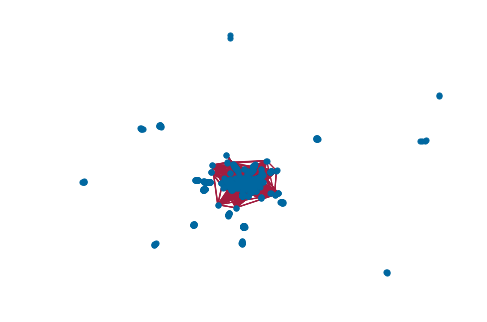

In [44]:
# Transform it in a links data frame (3 columns only):
links = Pearson_ρ.stack().reset_index()
links.columns = ['q1', 'q2','corr']
 
# Remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['q1'] != links['q2']) ]
links_filtered=links_filtered.assign(
    weight=links_filtered["corr"].apply(
        lambda x: 1/abs(x) if x != 0 else np.inf
    )
)

# Drop infinite-length edges
links_filtered = links_filtered.loc[links_filtered["weight"]!=np.inf].copy()

# Build your graph
G=nx.from_pandas_dataframe(links_filtered, 'q1', 'q2', 'weight')
 
# Plot the network:
nx.draw(
    G,
    with_labels=False,
    node_size=26,
    node_color='#0067a0',
    edge_color='#a31c3f',
    linewidths=1)

Export for Cytoscape

In [31]:
nx.write_graphml(G, "Pearson_ρ.graphml")

In [8]:
graphs = list(nx.connected_component_subgraphs(G))

In [33]:
for g in graphs:
    print(g.edges)

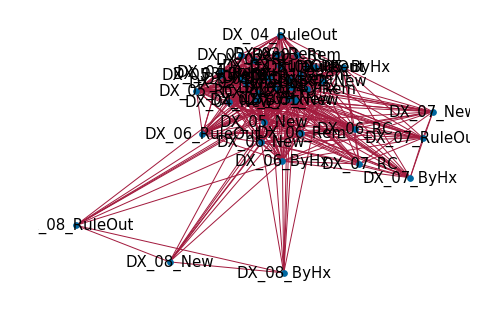

In [43]:
nx.draw(
    graphs[4],
    with_labels=True,
    node_size=32,
    node_color='#0067a0',
    edge_color='#a31c3f',
    linewidths=1,
    font_size=15
)

In [9]:
def jgraph_from_links_filtered(df):
    """
    Function to create a jgraph-readable dict from
    networkx-readable DataFrame
    
    Parameter
    ---------
    df: DataFrame
        three columns: source, destination, magnitude
        
    Returns
    -------
    jdict: dictionary
        dictionary of nodes and edges
    """
    edges = []
    for edge in df.iterrows():
        edges.append(
            {
                "source": edge[1][
                    df.columns[0]
                ],
                "target": edge[1][
                    df.columns[1]
                ],
                "edge_size": abs(
                    edge[1][
                        df.columns[2]
                    ]
                )
            }
        )
    jdict = {
        "nodes": {
            **{
                node: {} for node in list(
                    df[
                        df.columns[0]
                    ]
                )
            }, **{
                node: {} for node in list(
                    df[
                        df.columns[1]
                    ]
                )
            }
        },
        "edges": edges
    }
    return(jdict)

In [10]:
for subg in graphs:
    print(subg)

In [ ]:
jgraph.draw(J)

In [ ]:
J = jgraph_from_links_filtered(links_filtered)

In [ ]:
J